In [1]:
import os,sys
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 공통 변수
raw_data_name = 'scaled_eda2.csv'
output_csv_name = 'output4.csv'

# Code 경로 추가
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
print(sys.path[-1])

C:\Users\Minari\Documents\GitHub\level1-classificationinmachinelearning-recsys-06


In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv(raw_data_name)
df

,ID,_type,target,scaled_log_hashrate,scaled_log_open_interest,scaled_log_coinbase_premium_index,scaled_funding_rates,scaled_estimated_block_reward,scaled_liquidation_diff,scaled_log_total_liquidation,scaled_log_total_taker_volume,scaled_utxo_count,scaled_total_transactions_count,taker_buy_sell_ratio,moving_avg_scaled_log_total_volume,open_interest_diff
0,2023-01-01 00:00:00,train,2.0,0.343899,-2.074545,-1.004418,-0.190599,-2.283932,-0.013822,-1.407440,-1.507090,-1.216481,-0.616412,0.904774,-1.507090,NaN
1,2023-01-01 01:00:00,train,1.0,-0.479569,-2.055443,-0.920481,-0.190611,-2.271191,-0.020702,-1.089259,-1.998687,-1.216149,-1.202730,1.655721,-1.752889,1.733962e+07
2,2023-01-01 02:00:00,train,1.0,0.039981,-2.057519,-0.982775,-0.190679,-2.285286,-0.013936,-1.414659,-2.337608,-1.216188,-1.232124,1.027512,-1.947795,-1.886794e+06
3,2023-01-01 03:00:00,train,1.0,-0.312311,-2.059965,-0.995009,-0.188985,-2.286295,-0.008301,-1.132860,-2.043796,-1.215593,-1.263915,0.874477,-1.971795,-2.221901e+06
4,2023-01-01 04:00:00,train,2.0,-0.060107,-2.052255,-1.026415,-0.083030,-2.282372,-0.010506,-1.228120,-2.015961,-1.214962,-1.087030,0.966796,-1.980628,7.007341e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2024-04-26 03:00:00,test,NaN,-0.010992,3.897601,-0.295264,NaN,1.104435,-0.009503,-1.009395,NaN,3.500785,-0.763278,NaN,NaN,-2.193716e+07
11548,2024-04-26 04:00:00,test,NaN,0.508558,NaN,-0.487863,NaN,0.993608,0.047178,-0.177464,NaN,3.501430,NaN,NaN,NaN,NaN
11549,2024-04-26 05:00:00,test,NaN,0.508558,NaN,-0.232401,NaN,0.942780,-0.046429,-0.155122,NaN,3.502278,NaN,NaN,NaN,NaN
11550,2024-04-26 06:00:00,test,NaN,0.204640,NaN,-0.304981,NaN,0.805223,-0.022042,-0.663602,NaN,3.502337,NaN,NaN,NaN,NaN


In [3]:
df.isna().sum()

ID                                       0
_type                                    0
target                                2792
scaled_log_hashrate                      0
scaled_log_open_interest                 4
scaled_log_coinbase_premium_index        7
scaled_funding_rates                    32
scaled_estimated_block_reward           24
scaled_liquidation_diff                  0
scaled_log_total_liquidation             0
scaled_log_total_taker_volume           31
scaled_utxo_count                        1
scaled_total_transactions_count          4
taker_buy_sell_ratio                    31
moving_avg_scaled_log_total_volume       6
open_interest_diff                       5
dtype: int64

In [4]:
df['ID'] = pd.to_datetime(df['ID'])

In [5]:
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

In [6]:
# train_test_split 으로 valid set, train set 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df.drop(['target', 'ID'], axis = 1), 
    train_df['target'].astype(int), 
    test_size=0.2,
    random_state=42,
)

# lgb dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 4,
    'num_leaves': 50,
    'learning_rate': 0.05,
    'n_estimators': 30,
    'random_state': 42,
    'verbose': 0,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(X_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class='ovr')

print(f'acc: {accuracy}, auroc: {auroc}')

acc: 0.4178082191780822, auroc: 0.629916839264334


C:\Users\Minari\anaconda3\envs\bProject01\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [7]:
train_merged_df_with_target = X_train.copy()
train_merged_df_with_target['close'] = y_train

# 피어슨 상관계수 계산
correlation_matrix = train_merged_df_with_target.corr()

# 타겟과 각 피처 간의 상관계수만 추출 후 반환
correlation_matrix['close'].drop('close').sort_values(ascending=False)

scaled_liquidation_diff               0.025992
scaled_log_coinbase_premium_index     0.019331
scaled_log_total_liquidation          0.012603
scaled_log_total_taker_volume         0.010158
scaled_log_hashrate                   0.007928
moving_avg_scaled_log_total_volume    0.002084
scaled_total_transactions_count      -0.006974
scaled_utxo_count                    -0.007336
scaled_estimated_block_reward        -0.013124
scaled_log_open_interest             -0.015394
scaled_funding_rates                 -0.019453
open_interest_diff                   -0.021962
taker_buy_sell_ratio                 -0.041525
Name: close, dtype: float64

In [8]:
# importance gain 표시(영향을 끼친 정도)
f_import = lgb_model.feature_importance(importance_type='gain')
f_names = X_train.columns

ser = pd.Series(f_import, index=f_names, name='gain')

ser = ser / f_import.sum()

ser.sort_values(ascending=False, inplace=True)

ser

scaled_log_total_taker_volume         0.140241
scaled_utxo_count                     0.110395
scaled_log_coinbase_premium_index     0.081053
taker_buy_sell_ratio                  0.079818
scaled_liquidation_diff               0.079498
moving_avg_scaled_log_total_volume    0.073915
scaled_estimated_block_reward         0.073045
open_interest_diff                    0.071181
scaled_total_transactions_count       0.064820
scaled_log_open_interest              0.060092
scaled_funding_rates                  0.059782
scaled_log_hashrate                   0.054297
scaled_log_total_liquidation          0.051864
Name: gain, dtype: float64

In [9]:
# importance split 표시(영향을 끼친 횟수)
f_import = lgb_model.feature_importance(importance_type='split')
f_names = X_train.columns

ser = pd.Series(f_import, index=f_names, name='split')

ser.sort_values(ascending=False, inplace=True)

ser

scaled_log_total_taker_volume         561
taker_buy_sell_ratio                  555
scaled_log_coinbase_premium_index     540
open_interest_diff                    486
scaled_utxo_count                     478
moving_avg_scaled_log_total_volume    473
scaled_estimated_block_reward         441
scaled_total_transactions_count       436
scaled_funding_rates                  404
scaled_liquidation_diff               404
scaled_log_hashrate                   378
scaled_log_total_liquidation          365
scaled_log_open_interest              359
Name: split, dtype: int32

In [12]:
submission_df: pd.DataFrame = pd.read_csv(os.path.join('../../data/', 'test.csv'))

In [13]:
y_test_pred = lgb_model.predict(test_df.drop(['target', 'ID'], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

In [14]:
# 분포 확인
submission_df:pd.DataFrame = submission_df.assign(target = y_test_pred_class)
submission_df['target'].value_counts()

target
2    1623
1    1098
3      62
0       9
Name: count, dtype: int64

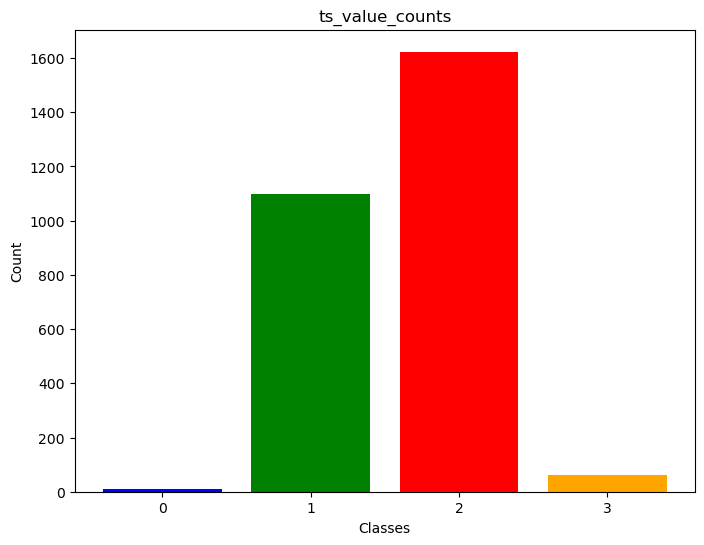

In [15]:
submission_df_value = submission_df['target'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(submission_df_value.index, submission_df_value.values, color=['blue', 'green', 'red', 'orange'])
plt.xticks([0, 1, 2, 3])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('ts_value_counts')
plt.show()

In [16]:
from time_series_CV import TimeSeriesCV as tsCV
ts = tsCV(train_df)
ts.train()

Fold accuracy: 0.40616438356164386
Fold accuracy: 0.4143835616438356
Fold accuracy: 0.37397260273972605
Fold accuracy: 0.4465753424657534
Fold accuracy: 0.4383561643835616
     Fold  Accuracy
0  Fold 1  0.406164
1  Fold 2  0.414384
2  Fold 3  0.373973
3  Fold 4  0.446575
4  Fold 5  0.438356


In [17]:
ts.print_performance()

F1 Score: 0.24706146282521999
Precision: 0.41475632005219554
Recall: 0.2669611996768524
Confusion Matrix: 
[[  2  44  73   0]
 [  3 236 341   0]
 [  2 226 401   1]
 [  0  47  83   1]]


In [18]:
ts_pred = ts.model.predict(test_df.drop(["target", "ID"], axis = 1))
ts_submission_df = submission_df.assign(target = ts_pred)
ts_submission_df['target'].value_counts()

target
2    1787
1     932
3      41
0      32
Name: count, dtype: int64

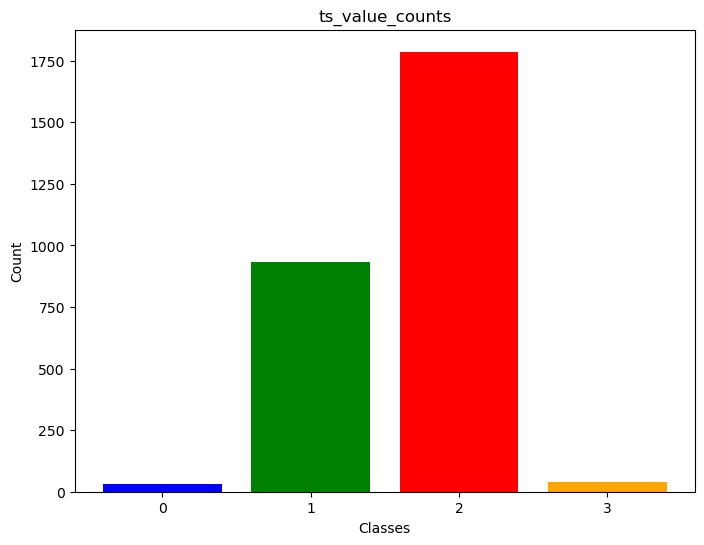

In [19]:
ts_value_counts = ts_submission_df['target'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(ts_value_counts.index, ts_value_counts.values, color=['blue', 'green', 'red', 'orange'])
plt.xticks([0, 1, 2, 3])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('ts_value_counts')
plt.show()

In [20]:
submission_df: pd.DataFrame = pd.read_csv(os.path.join('../../data/', "test.csv"))
y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)
ts_submission_df = ts_submission_df.assign(target = y_test_pred_class)
ts_submission_df.to_csv(output_csv_name, index=False)